In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [194]:
# Calculate the truncated average for each row
def truncated_mean(row):
    # Drop NaN values
    row = row.dropna()
    #removing min and max before average
    current_values = row[1:].tolist()
    current_values.remove(min(current_values))
    current_values.remove(max(current_values))
    # Calculate the mean
    return np.mean(current_values)


def readingOneFile(path_to_file):
    # reade the file
    VI_1col = pd.read_csv(path_to_file, delimiter=',')

    # Reshape the data
    VI = VI_1col.pivot_table(index='Sourced_voltage', 
                             columns=VI_1col.groupby('Sourced_voltage').cumcount(), 
                             values='Channel_Current').reset_index()
    
    # Apply the truncated_mean function to each row
    VI['Current_Average'] = VI.iloc[:].apply(truncated_mean, axis=1)
    return VI


def plottingOneIVCurve(pd):
    fig, ax = plt.subplots(1,2, figsize=(15,7), width_ratios=[2, 3])
    
    ax[0].plot(pd['Sourced_voltage'][:19], pd['Current_Average'][:19], 'o-')
    ax[0].grid(axis='y', color='0.90')
    ax[0].grid(axis='x', color='0.90')
    ax[0].set_xlabel("Voltage (V)", fontsize=12)
    ax[0].set_ylabel("Current (A)", fontsize=12)
    ax[0].set_title("Forward IV curve", fontsize=12)

    ax[1].plot(pd['Sourced_voltage'][19:], abs(pd['Current_Average'][19:]), 'o-')
    ax[1].grid(axis='y', color='0.90')
    ax[1].grid(axis='x', color='0.90')
    ax[1].set_xlabel("Voltage (V)", fontsize=12)
    ax[1].set_ylabel("Current (A)", fontsize=12)
    ax[1].set_title("Reverse IV curve", fontsize=12)
    ax[1].set_yscale('log')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [195]:
VI = readingOneFile("/home/shideh/Downloads/FBK_TILE01_CHxx.txt") 
VI

,Sourced_voltage,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,38,39,Current_Average
0,-1.500000,7.781470e-04,7.781450e-04,7.781700e-04,7.781630e-04,7.781700e-04,7.781590e-04,7.781630e-04,7.781580e-04,7.781630e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.781676e-04
1,-1.421053,7.121610e-04,7.121590e-04,7.121780e-04,7.121580e-04,7.121560e-04,7.121570e-04,7.121640e-04,7.121710e-04,7.121500e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.121623e-04
2,-1.342105,6.463840e-04,6.463840e-04,6.463990e-04,6.463800e-04,6.463860e-04,6.464000e-04,6.464010e-04,6.463930e-04,6.463960e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.463950e-04
3,-1.263158,5.808940e-04,5.809120e-04,5.809060e-04,5.808980e-04,5.808990e-04,5.809000e-04,5.809110e-04,5.808910e-04,5.808950e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.809036e-04
4,-1.184211,5.158030e-04,5.157930e-04,5.157980e-04,5.157930e-04,5.157980e-04,5.157960e-04,5.157820e-04,5.157890e-04,5.158000e-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.157952e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,40.000000,-7.687300e-07,-7.804090e-07,-7.718050e-07,-7.991980e-07,-7.915810e-07,-7.937200e-07,-7.785890e-07,-8.001300e-07,-7.715590e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.879941e-07
59,40.500000,-9.174200e-07,-9.062100e-07,-9.032400e-07,-8.974240e-07,-9.264600e-07,-8.969300e-07,-8.909390e-07,-9.006700e-07,-8.966700e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.007519e-07
60,41.000000,-1.026640e-06,-1.024470e-06,-1.024650e-06,-1.035390e-06,-1.017110e-06,-1.035460e-06,-1.018730e-06,-1.038280e-06,-1.023350e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.022512e-06
61,41.500000,-1.121720e-06,-1.138710e-06,-1.140240e-06,-1.149000e-06,-1.154640e-06,-1.191330e-06,-1.153440e-06,-1.172600e-06,-1.178980e-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.156121e-06


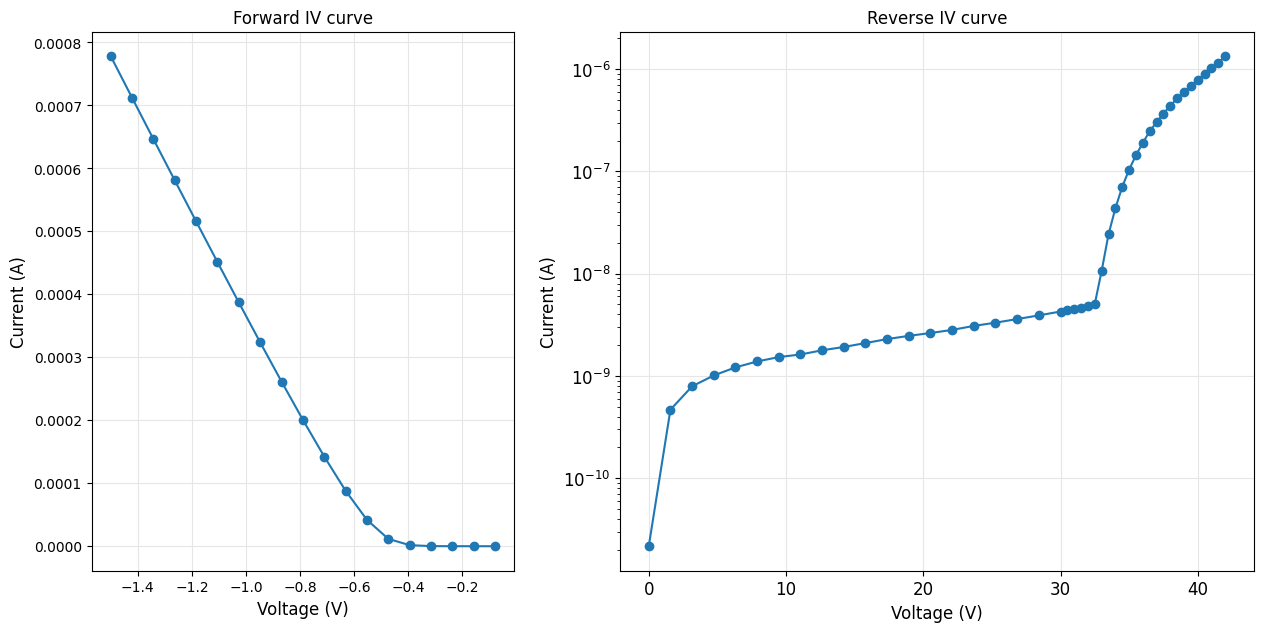

In [196]:
plottingOneIVCurve(VI)

In [ ]:
# read temperature data
temp_hum = pd.read_csv('/home/shideh/Work/Sr90_01_test_results/result_from_clean_room/Results_cleanroom/temp_humi_log.csv')

time_list_temp = []
date_list_temp = []
for i in temp_hum['Datetime']:
    date_list_temp.append(datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f'))
    time = (datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f') - datetime.datetime.strptime(list(dfraw)[1], '%Y_%b_%d_%H_%M')).total_seconds()/60/60
    time_list_temp.append(time)

temp_func = scipy.interpolate.interp1d(time_list_temp, temp_hum['Temperature'])
time_new = np.arange(time_list_temp[0],time_list_temp[-1], 0.001)
temp_new = temp_func(time_new)


plt.plot(time_list_temp[:], temp_hum['Temperature'][:], color = 'g', label='data')
plt.scatter(time_new, temp_new, marker='o', color = 'lightgreen', alpha=0.2, label='fit')
plt.grid()
plt.xlabel("time (hr)")
plt.ylabel('Temperature')
plt.legend()